In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Single Task approach**:

Experimental Settings:       
Twitter word settings:

* window = 3 tokens
* embeddings -> twitter pre-trained embeddings, Godin
* dimensions = 400
* LSTM units = 100 -> 200 (Bi-LSTM)

Other settings:

* Epochs -> 150
* Batch size -> 500
* Optimizer -> Admax
* Seed 1337 for reproducibility

In [ ]:
# Install required packages
!pip install python-crfsuite

     |████████████████████████████████| 743 kB 6.7 MB/s 


### Download the Word2vec model

https://github.com/FredericGodin/TwitterEmbeddings     
https://drive.google.com/file/d/1lw5Hr6Xw0G0bMT1ZllrtMqEgCTrM7dzc/view

In [ ]:
# Change path to NER-WNUT17
import os
os.chdir('/content/drive/MyDrive/NER-WNUT17/NER-WNUT17')

In [ ]:
experiment = 'notebook'

# os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda,floatX=float64"
import sys
sys.path += [new_path 
             for new_path in ['..', 
                              '../embeddings/twitter'] 
             if new_path not in sys.path]

import numpy as np
seed_number = 1337
np.random.seed(seed_number)  # for reproducibility

import pycrfsuite as crf
import matplotlib.pyplot as plt
import common.utilities as utils

from settings import *
from pycrfsuite import ItemSequence
from collections import Counter, defaultdict as ddict
from embeddings.twitter.word2vecReader import Word2Vec, Vocab
from sklearn.metrics import confusion_matrix, classification_report   
from sklearn.preprocessing import LabelBinarizer

from keras.models import Model
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalAveragePooling1D
from keras.optimizers import Adamax
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import RandomUniform

### Loading data

In [ ]:
tweets_train, labels_train = utils.read_file_as_lists(TRAIN_PREPROC_URL)
tweets_dev,   labels_dev   = utils.read_file_as_lists(DEV_PREPROC_URL)
tweets_test,  labels_test  = utils.read_file_as_lists(TEST_PREPROC_URL)

tweets_train += tweets_dev
labels_train += labels_dev

vocabulary = list(set(utils.flatten(tweets_train + tweets_test)))

print("Vocabulary:", len(vocabulary))

Vocabulary: 19329


In [ ]:
labels_train

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-location',
  'I-location',
  'I-location',
  'O',
  'B-location',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'B-group',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['B-corporation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['B-person', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'B-creative-work',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

### Loading POS Tags

In [ ]:
pos_tweets_train, postags_train = utils.read_file_as_lists(TRAIN_PREPROC_URL_POSTAG)
pos_tweets_dev,   postags_dev   = utils.read_file_as_lists(DEV_PREPROC_URL_POSTAG)
pos_tweets_test,  postags_test  = utils.read_file_as_lists(TEST_PREPROC_URL_POSTAG)

pos_tweets_train += pos_tweets_dev
postags_train += postags_dev

utils.sync_postags_and_tweets(tweets_train, pos_tweets_train, postags_train) 
utils.sync_postags_and_tweets(tweets_test, pos_tweets_test, postags_test)

### Loading Twitter embeddings

In [ ]:
%%time 
w2v_model = Word2Vec.load_word2vec_format(W2V_TWITTER_EMB_GODIN, binary=True)
twitter_vb = {token:v.index for token,v in w2v_model.vocab.items()}

# Using only needed embeddings (faster this way)
twitter_index2word, twitter_embeddings = utils.pick_embeddings_by_indexes(vocabulary, w2v_model.syn0, twitter_vb)
twitter_index2word = [PAD_TOKEN, UNK_TOKEN] + twitter_index2word
twitter_word2index = ddict(lambda: twitter_index2word.index(UNK_TOKEN), {w:i for i,w in enumerate(twitter_index2word)})
twitter_embeddings = np.append(np.zeros((2,twitter_embeddings.shape[1])), twitter_embeddings, axis=0)

CPU times: user 1min 9s, sys: 7.22 s, total: 1min 16s
Wall time: 2min 47s


### Encoding words and labels

In [ ]:
window = 1

x_word_twitter_train = utils.build_x_matrix(window, [[twitter_word2index[token] for token in tweet] for tweet in tweets_train], twitter_word2index[PAD_TOKEN])
x_word_twitter_test  = utils.build_x_matrix(window, [[twitter_word2index[token] for token in tweet] for tweet in tweets_test], twitter_word2index[PAD_TOKEN])

index2label_cat = [
    'B-corporation',
    'B-creative-work',
    'B-group',
    'B-location',
    'B-person',
    'B-product',
    'I-corporation',
    'I-creative-work',
    'I-group',
    'I-location',
    'I-person',
    'I-product',
    'O'
]

y_cat_train, label2index_cat, _ = utils.vectorize_labels(labels_train, index2label_cat)

### Encoding POS tags

In [ ]:
index2postag = [PAD_TOKEN] + list(set(utils.flatten(postags_train + postags_test)))
postag2index = {w:i for i,w in enumerate(index2postag)}

x_postag_train = utils.build_x_matrix(window, [[postag2index[token] for token in tweet] for tweet in postags_train], postag2index[PAD_TOKEN])
x_postag_test  = utils.build_x_matrix(window, [[postag2index[token] for token in tweet] for tweet in postags_test], postag2index[PAD_TOKEN])

In [ ]:
def get_input_layer(shape, name):
    return Input(shape=shape, dtype='int32', name='{}_input'.format(name))

def pretrained_embedding_layer(embeddings, input_layer, input_len, name):
    embed_layer = Embedding(embeddings.shape[0], 
                           embeddings.shape[1], 
                           input_length=input_len, 
                           weights=[embeddings],
                           trainable=False,
                           name='{}_embed'.format(name))(input_layer)
    embed_layer = Dropout(0.5, name='{}_embed_dropout'.format(name))(embed_layer)
    return embed_layer
    
    
def rand_uniform_embedding_layer(input_layer, input_dim, output_dim, input_len, name):
    uniform = RandomUniform(seed=seed_number, 
                            minval=-np.sqrt(3/output_dim),  # Suggested by
                            maxval= np.sqrt(3/output_dim))  # He et al (2015) 
    embed_layer = Embedding(input_dim=input_dim, 
                            output_dim=output_dim,
                            input_length=input_len, 
                            embeddings_initializer=uniform,
                            trainable=False,
                            name='{}_embed'.format(name))(input_layer)
    embed_layer = Dropout(0.5, name='{}_embed_dropout'.format(name))(embed_layer)
    return embed_layer

### Neural network- Word representation

In [ ]:
twitter_input = get_input_layer((window*2+1,), 'word_twitter')
twitter_embed = pretrained_embedding_layer(twitter_embeddings, 
                                           twitter_input, 
                                           window*2+1, 
                                           'word_twitter')

postag_dim = 100
postag_input = get_input_layer((window*2+1,), 'word_postag')
postag_embed = rand_uniform_embedding_layer(postag_input, 
                                            len(index2postag), 
                                            postag_dim,
                                            window*2+1, 
                                            'word_postag')

### BiLSTM Network

In [ ]:
word_encoded = concatenate([twitter_embed, postag_embed], axis=2)
word_encoded = Bidirectional(LSTM(100, 
                                  return_sequences=False, 
                                  dropout=0.2, 
                                  recurrent_dropout=0.2), 
                             name='word_encoded_blstm')(word_encoded)
word_encoded = Dropout(0.5, name='word_encoded_blstm_dropout')(word_encoded)
word_encoder = Model(inputs=[twitter_input, 
                             postag_input, 
                             ], outputs=[word_encoded])
word_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_twitter_input (InputLayer) [(None, 3)]          0                                            
__________________________________________________________________________________________________
word_postag_input (InputLayer)  [(None, 3)]          0                                            
__________________________________________________________________________________________________
word_twitter_embed (Embedding)  (None, 3, 400)       6066400     word_twitter_input[0][0]         
__________________________________________________________________________________________________
word_postag_embed (Embedding)   (None, 3, 100)       10200       word_postag_input[0][0]          
______________________________________________________________________________________________

### Build a NN model

In [ ]:
network = word_encoded
network = Dense(100, activation='relu', name='common_dense_layer') (network)

cat_output = Dense(len(index2label_cat), activation='softmax', name='cat_output')(network)

word_inputs = [twitter_input, postag_input]
model = Model(inputs=word_inputs, 
              outputs=[cat_output], 
              name='ne_model')
model.summary()

Model: "ne_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_twitter_input (InputLayer) [(None, 3)]          0                                            
__________________________________________________________________________________________________
word_postag_input (InputLayer)  [(None, 3)]          0                                            
__________________________________________________________________________________________________
word_twitter_embed (Embedding)  (None, 3, 400)       6066400     word_twitter_input[0][0]         
__________________________________________________________________________________________________
word_postag_embed (Embedding)   (None, 3, 100)       10200       word_postag_input[0][0]          
___________________________________________________________________________________________

In [ ]:
# Change dtype from float32 to int64
y_cat_train = y_cat_train.astype('int64')

In [ ]:
adamax = Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adamax,
              loss={'cat_output': 'categorical_crossentropy'},
              loss_weights={'cat_output': 1.},
              metrics={'cat_output': ['accuracy']})

early_stopping = EarlyStopping(patience=20, verbose=1)
# checkpointer = ModelCheckpoint(filepath='{}weights/{}.hdf5'.format(WEIGHTS_DIR, experiment),
#                                save_best_only=True, verbose=1)
train_word_values = [x_word_twitter_train, x_postag_train]
hist = model.fit(train_word_values, 
                 {'cat_output': y_cat_train}, 
                 batch_size=500, 
                 epochs=150, 
                 verbose=1, 
                 shuffle=True,
                 validation_split=0.2,
                 callbacks=[early_stopping])           # , checkpointer])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
126/126 [==============================] - 33s 47ms/step - loss: 1.0971 - accuracy: 0.8604 - val_loss: 0.4233 - val_accuracy: 0.9206
Epoch 2/150
126/126 [==============================] - 4s 35ms/step - loss: 0.2827 - accuracy: 0.9491 - val_loss: 0.3958 - val_accuracy: 0.9206
Epoch 3/150
126/126 [==============================] - 4s 35ms/step - loss: 0.2535 - accuracy: 0.9501 - val_loss: 0.3644 - val_accuracy: 0.9208
Epoch 4/150
126/126 [==============================] - 4s 35ms/step - loss: 0.2368 - accuracy: 0.9494 - val_loss: 0.3516 - val_accuracy: 0.9208
Epoch 5/150
126/126 [==============================] - 4s 34ms/step - loss: 0.2272 - accuracy: 0.9491 - val_loss: 0.3198 - val_accuracy: 0.9224
Epoch 6/150
126/126 [==============================] - 4s 34ms/step - loss: 0.2052 - accuracy: 0.9515 - val_loss: 0.3071 - val_accuracy: 0.9243
Epoch 7/150
126/126 [==============================] - 4s 35ms/step - loss: 0.1904 - accuracy: 0.9553 - val_loss: 0.2929 - val_accuracy

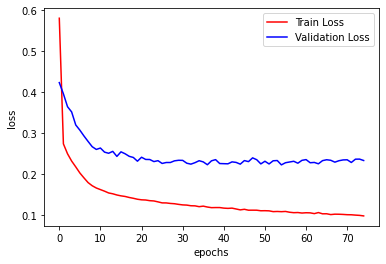

In [ ]:
# Plot train & validation loss
train_loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
plt.plot(range(len(train_loss)), train_loss, color="red", label="Train Loss")
plt.plot(range(len(train_loss)), val_loss, color="blue", label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

### Neural Network Predictions

In [ ]:
cat_model = Model(inputs=word_inputs, 
                  outputs=[cat_output], 
                  name='cat_model')

In [ ]:
# Predicting test data
test_word_values = [x_word_twitter_test, x_postag_test]

prediction_probs = cat_model.predict(test_word_values, batch_size=500, verbose=1)
# Decoding predictions
decoded_predictions = utils.decode_predictions([np.argmax(p) for p in prediction_probs], index2label_cat)

47/47 [==============================] - 2s 5ms/step


In [ ]:
original_test_tweets,_ = utils.read_file_as_lists(TEST)

assert len(original_test_tweets) == len(tweets_test)
assert len(utils.flatten(original_test_tweets)) == len(utils.flatten(tweets_test))
assert len(utils.flatten(original_test_tweets)) == len(decoded_predictions)
    
utils.save_final_predictions('{}{}.network.tsv'.format(PREDICTIONS_DIR, experiment), 
                             original_test_tweets,
                             decoded_predictions)

### NN Predection insights

In [ ]:
print("Classification Report\n")
print(classification_report(utils.flatten(labels_test), decoded_predictions))

Classification Report

                 precision    recall  f1-score   support

  B-corporation       0.26      0.15      0.19        66
B-creative-work       0.45      0.04      0.07       142
        B-group       0.59      0.15      0.23       165
     B-location       0.57      0.51      0.54       150
       B-person       0.78      0.49      0.60       429
      B-product       0.72      0.17      0.27       127
  I-corporation       1.00      0.05      0.09        22
I-creative-work       0.56      0.02      0.04       218
        I-group       0.50      0.06      0.10        70
     I-location       0.71      0.27      0.39        94
       I-person       0.76      0.54      0.63       131
      I-product       0.62      0.17      0.26       126
              O       0.95      1.00      0.97     21654

       accuracy                           0.94     23394
      macro avg       0.65      0.28      0.34     23394
   weighted avg       0.93      0.94      0.93     23394



### CRF-Suite Predictions

In [ ]:
nn_model = Model(inputs=model.input, outputs=model.get_layer('common_dense_layer').output)

def get_xseq(model, matrix):
    xseq = [{'feat{}'.format(i):float(w) for i,w in enumerate(list(features))} 
            for features 
            in model.predict(matrix)]
    return ItemSequence(xseq)

xseq_train = get_xseq(nn_model, train_word_values)
yseq_train = utils.flatten(labels_train)

trainer = crf.Trainer(verbose=False)
trainer.append(xseq_train, yseq_train)
trainer.set_params({
    'c1': 1.0,                           # L1 penalty
    'c2': 1e-3,                          # L2 penalty
    'max_iterations': 100,               # stop earlier
    'feature.possible_transitions': True # possible transitions, but not observed
})
trainer.train('{}.pycrfsuite'.format(experiment))
trainer.logparser.last_iteration

tagger = crf.Tagger()
tagger.open('{}.pycrfsuite'.format(experiment))

# Predicting test data
decoded_predictions_crf = tagger.tag(get_xseq(nn_model, 
                                          test_word_values))

# Saving predictions
utils.save_final_predictions('{}{}.crfsuite.tsv'.format(PREDICTIONS_DIR, experiment), 
                             original_test_tweets,
                             decoded_predictions_crf)

### CRF Prediction insigths

In [ ]:
print("Classification Report\n")
print(classification_report(utils.flatten(labels_test), decoded_predictions_crf))

Classification Report

                 precision    recall  f1-score   support

  B-corporation       0.35      0.26      0.30        66
B-creative-work       0.42      0.07      0.12       142
        B-group       0.51      0.18      0.27       165
     B-location       0.62      0.53      0.57       150
       B-person       0.76      0.50      0.60       429
      B-product       0.62      0.20      0.30       127
  I-corporation       0.60      0.14      0.22        22
I-creative-work       0.37      0.06      0.11       218
        I-group       0.39      0.16      0.22        70
     I-location       0.58      0.23      0.33        94
       I-person       0.78      0.55      0.65       131
      I-product       0.66      0.32      0.43       126
              O       0.95      0.99      0.97     21654

       accuracy                           0.94     23394
      macro avg       0.59      0.32      0.39     23394
   weighted avg       0.93      0.94      0.93     23394



###Save the predictions

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(utils.flatten(labels_test), columns=['true_labels'])
df['nn_predictions'] = decoded_predictions
df['crf_predictions'] = decoded_predictions_crf

df.to_csv('single_task_results.csv', index=False)